In [1]:
import numpy as np
import pandas as pd
import math
import cPickle as pickle

# Data Parsing


In [2]:
file = '/Users/JH/Desktop/NTU/NTU_Research/data/NEM_Load_Forecasting_Database.xls'

QLD = 'Actual_Data_QLD'
NSW = 'Actual_Data_NSW'
VIC = 'Actual_Data_VIC'
SA = 'Actual_Data_SA'
TAS = 'Actual_Data_TAS'

In [3]:
# Set Classes as Data Container

class Structure:
    def __init__(self):
        self._feature = []
        self._target = []

    @property
    def feature(self):
        return self._feature

    @property
    def target(self):
        return self._target

    @feature.setter
    def feature(self, value):
        self._feature = value

    @target.setter
    def target(self, value):
        self._target = value


class Data:
    def __init__(self):
        pass

    class Train(Structure):
        def __init__(self):
            pass

    class Test(Structure):
        def __init__(self):
            pass


class DataSet:
    def __init__(self):
        pass

    class Raw:
        def __init__(self):
            pass

        class Train(Structure):
            def __init__(self):
                pass

        class Test(Structure):
            def __init__(self):
                pass

    class PreProcessed:
        def __init__(self):
            pass

        class Train(Structure):
            def __init__(self):
                pass

        class Test(Structure):
            def __init__(self):
                pass

In [4]:
# Set Functions

def normalization(data):
    return (data - min(data)) / (max(data) - min(data))


def data_splitter(data, ratio=0.8):
    """
    split data into training data & testing data
    :param data:

    :param ratio:
        training data ratio
    :return:
        train_data, test_data
    """
    splitter = int(len(data) * ratio)
    return np.array(data[:splitter]), np.array(data[splitter + 1:])


def preprocessing_filter(data, nominator, denominator):
    return normalization(data) ** (nominator / denominator)


def preprocessing(data_present, temperature_max, temperature_mean, denominator):
    data_present = list(data_present) + list(
        preprocessing_filter(np.array(data_present), temperature_max, denominator)) + list(
        preprocessing_filter(np.array(data_present), temperature_mean, denominator))

    return np.array(data_present)


def data_alloter(df):
    dataset = DataSet()
    denominator = df['Mean Tem.'].min()

    raw_feature = []
    raw_target = []
    preprocessed_feature = []
    preprocessed_target = []

    for row in range(0, len(df)):
        # if both MaxTemp and MeanTemp are not nan
        if not math.isnan(df['Max Tem.'][row]) and not math.isnan(df['Mean Tem.'][row]):
            if not math.isnan(df['Max Tem.'][row + 1]) and not math.isnan(df['Mean Tem.'][row + 1]):
                powerload_present = normalization(np.array(df.loc[row][5:53]))
                powerload_future = normalization(np.array(df.loc[row + 1][5:53]))

                raw_feature.append(np.array(
                    list(powerload_present) + list([df['Max Tem.'][row + 1]]) + list([df['Mean Tem.'][row + 1]])))
                raw_target.append(np.array(powerload_future))

                preprocessed_powerload_present = preprocessing(powerload_present,
                                                               df['Max Tem.'][row + 1],
                                                               df['Mean Tem.'][row + 1],
                                                               denominator)

                preprocessed_feature.append(preprocessed_powerload_present)
                preprocessed_target.append(np.array(powerload_future))

    dataset.Raw.Train.feature, dataset.Raw.Test.feature = data_splitter(raw_feature)
    dataset.Raw.Train.target, dataset.Raw.Test.target = data_splitter(raw_target)

    dataset.PreProcessed.Train.feature, dataset.PreProcessed.Test.feature = data_splitter(preprocessed_feature)
    dataset.PreProcessed.Train.target, dataset.PreProcessed.Test.target = data_splitter(preprocessed_target)

    return dataset

In [5]:
df = pd.read_excel(file, sheetname=QLD)
dataset = data_alloter(df)

### Parsed Data Checking

# DeepLearning Core

## Training

In [6]:
import tensorflow as tf

In [7]:
# Parameters
"""
learning_rate = 0.01
training_iters = 3000
display_step = 100
"""
batch_size = 50
num_steps = 5000
data_showing_step = 200

# Network Parameters
n_input = 144  # feature data as input (input matrix shape: ???)
n_output = 48  # target data as output  (48-points)
dropout = 0.75  # Dropout, probability to keep units

In [8]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input], name='feature_input')
y = tf.placeholder(tf.float32, [None, n_output], name='target_output')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')  # dropout (keep probability)
learning_rate_decayed = tf.placeholder(tf.float32, shape=[])

In [9]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [10]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    with tf.name_scope('array_reshape') as array_reshape:
        x = tf.reshape(x, shape=[-1, 12, 12, 1])

    # Convolution Layer
    with tf.name_scope('conv_layer1') as conv_layer1:
        conv1 = conv2d(x, weights['wc1'], biases['bc1'])
        # Max Pooling (down-sampling)
        conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    with tf.name_scope('conv_layer2') as conv_layer2:
        conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
        # Max Pooling (down-sampling)
        conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    with tf.name_scope('fc_layer') as fc_layer:
        fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
        fc1 = tf.nn.relu(fc1)
        # Apply Dropout
        fc1 = tf.nn.dropout(fc1, dropout)
        
        fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
        fc2 = tf.nn.relu(fc2)
        # Apply Dropout
        fc2 = tf.nn.dropout(fc2, dropout)

    # Output, class prediction
    with tf.name_scope('output_layer') as output_layer:
        out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
        # out = tf.div(tf.subtract(out, tf.reduce_min(out)), tf.subtract(tf.reduce_max(out), tf.reduce_min(out)))
        # out = tf.sigmoid(out)
    
    return out

In [11]:
# Store layers weight & bias
weights = {
    # 3x3 conv, 1 input, 32 outputs(number of filter = 32)
    'wc1': tf.Variable(tf.truncated_normal([3, 3, 1, 32]), name='wc1'),
    
    # 3x3 conv, 32 inputs, 64 outputs(number of filter = 64)
    'wc2': tf.Variable(tf.truncated_normal([3, 3, 32, 64]), name='wc2'),
    
    # fully connected 1, width*height*64 inputs, ___ outputs
    'wd1': tf.Variable(tf.truncated_normal([3 * 3 * 64, 64*9]), name='wd1'),
    
    # fully connected 2, width*height*64 inputs, ___ outputs
    'wd2': tf.Variable(tf.truncated_normal([64*9, 64*6]), name='wd2'),
    
    # ___ inputs, 48 outputs
    'out': tf.Variable(tf.truncated_normal([64*6, n_output]), name='wo1')
}

biases = {
    'bc1': tf.Variable(tf.truncated_normal([32]), name='bc1'),
    'bc2': tf.Variable(tf.truncated_normal([64]), name='bc2'),
    'bd1': tf.Variable(tf.truncated_normal([64*9]), name='bd1'),
    'bd2': tf.Variable(tf.truncated_normal([64*6]), name='bd2'),
    'out': tf.Variable(tf.truncated_normal([n_output]), name='bo1')
}

In [12]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
with tf.name_scope('cost'):
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=pred, labels=y))
    #cost = tf.reduce_sum(tf.pow(pred-y, 2))/(2*n_output)
    tf.summary.scalar('cost/', cost)
    
with tf.name_scope('optimization'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_decayed).minimize(cost)

# Evaluation model
with tf.name_scope('evaluation'):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y, pred))))

# Initializing the variables
init = tf.global_variables_initializer()

In [13]:
# Launch the graph
sess = tf.InteractiveSession()
sess.run(init)

# Training cycle
for step in range(num_steps):
    
    avg_cost = 0.
    total_batch = int(dataset.PreProcessed.Train.feature.shape[0]/batch_size)
    
    if 500 < step < 2000:
        learning_rate = 0.01 / 100
    elif 2000 <= step < 10000:
        learning_rate = 0.01 / 10000
    else:
        learning_rate = 0.01

    # set a offset
    offset = (step * batch_size) % (dataset.PreProcessed.Train.target.shape[0] - batch_size)
    
    # Generate a minibatch.
    batch_x = dataset.PreProcessed.Train.feature[offset:(offset + batch_size), :]
    batch_y = dataset.PreProcessed.Train.target[offset:(offset + batch_size), :]
    
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, 
                                   keep_prob: 1., 
                                   learning_rate_decayed: learning_rate})
    
    c = sess.run(cost, feed_dict={x: batch_x, y: batch_y, 
                                  keep_prob: 0.8})
    
    # Compute average loss
    avg_cost += c / total_batch
    
    if (step % data_showing_step == 0):
        print "step:", '%04d' % (step), "cost=", "{:.9f}".format(avg_cost)
        
print "Optimization Finished!"

print "Training Accuracy [RMSE] :",\
    sess.run(rmse, feed_dict={x: dataset.PreProcessed.Train.feature, 
                              y: dataset.PreProcessed.Train.target,
                              keep_prob: 1.})

step: 0000 cost= 2189.961588542
step: 0200 cost= 70.959208171
step: 0400 cost= 31.498794556
step: 0600 cost= 28.160486857
step: 0800 cost= 25.795776367
step: 1000 cost= 27.609540304
step: 1200 cost= 25.844362895
step: 1400 cost= 27.805704753
step: 1600 cost= 27.798011780
step: 1800 cost= 27.396728516
step: 2000 cost= 26.759791056
step: 2200 cost= 26.695343018
step: 2400 cost= 27.158269246
step: 2600 cost= 26.193893433
step: 2800 cost= 28.964617411
step: 3000 cost= 25.686663310
step: 3200 cost= 29.834086100
step: 3400 cost= 26.103017171
step: 3600 cost= 29.232577006
step: 3800 cost= 23.359743754
step: 4000 cost= 29.641972860
step: 4200 cost= 24.140243530
step: 4400 cost= 27.960543315
step: 4600 cost= 23.277183533
step: 4800 cost= 27.612800598
Optimization Finished!
Training Accuracy [RMSE] : 197.475


## Testing

In [14]:
print "Testing Accuracy [RMSE] :",\
    sess.run(rmse, feed_dict={x: dataset.PreProcessed.Test.feature, 
                              y: dataset.PreProcessed.Test.target, 
                              keep_prob: 1.})

Testing Accuracy [RMSE] : 197.475


In [15]:
predict = sess.run(pred, feed_dict={x: dataset.PreProcessed.Test.feature,
                                    y: dataset.PreProcessed.Test.target, 
                                    keep_prob: 1.})

In [16]:
print predict[11]

[-202.67280579 -161.90013123    1.27205336  -58.90745926 -177.0431366
   61.14464951 -131.2250824  -326.53945923 -825.79174805  241.75012207
 -215.07138062   22.83649063  -86.8399353   -81.98259735   88.76677704
   87.76670837  135.01686096   69.42832947  175.41036987   60.30424881
   81.53653717   40.98570251  200.64181519   90.91418457  -58.89487076
  -91.32221985 -165.9336853   211.9519043    58.76681137  184.85626221
 -183.37001038  -60.20895386 -102.54679108  167.14021301   64.90293121
  -10.05959892  405.3664856  -114.2379837   275.11480713  210.20922852
  412.09750366  246.96696472    5.13464928  194.30975342  -82.94734955
   65.82064056  100.56491089 -154.93659973]


In [17]:
print dataset.PreProcessed.Test.target[11]

[0.39805697781278704 0.28611439324318383 0.22244103102708826
 0.14778346680670426 0.089624086473239384 0.040042011290534342
 0.019211413067261672 0.0 0.010940440243315393 0.030195615071550486
 0.077458316922672993 0.19005732790687471 0.32746925736291604
 0.52465975230843287 0.74841363616471934 0.93278193514507046 1.0
 0.96849153209925165 0.90678744912695286 0.89729114699575518
 0.85939346199291045 0.82031420944378819 0.80101527285457974
 0.77965953349962802 0.7621110673493503 0.75191457704258025
 0.74745087742330774 0.69848146689422774 0.68999168526541521
 0.68242090061704086 0.67576911294910513 0.66404096100827092
 0.65375694717955446 0.72246291190757517 0.78898078858693277
 0.90578092862456772 0.99186031245897355 0.97278018467463134
 0.9569821889632838 0.90004813793707072 0.9035053170539582
 0.89750995580062143 0.82486543258500722 0.76377401426633396
 0.68863507067524388 0.60618791300161923 0.56054439630650732
 0.52190276136711733]


In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook

/Users/JH/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


<IPython.core.display.Javascript object>


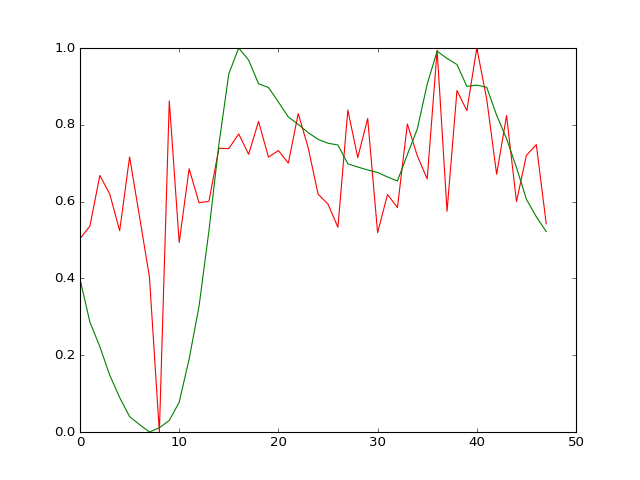

In [19]:
time = np.arange(0, 48, 1)

plt.plot(time, normalization(predict[11]), 'r', 
         time, dataset.PreProcessed.Test.target[11], 'g')
plt.show()
